In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import pandas as pd
import os
import inspect
import numpy as np
import pickle
import sys
import joblib
import matplotlib
import itertools

import torch.nn.functional as F
from collections import defaultdict as ddict
from multiprocessing import Pool
from functools import partial
from matplotlib import pyplot as plt, cm
from ipywidgets import *
from IPython.display import display, SVG
from pytoune.utils import torch_to_numpy
from sklearn.metrics import precision_score, roc_auc_score as sk_roc_auc, average_precision_score as sk_pr_auc
from torch.nn.functional import binary_cross_entropy
from sklearn.utils import resample 

from copy import deepcopy
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.csgraph import csgraph_from_dense
from rdkit import Chem
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D, MolsToGridImage
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import rdDepictor
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors, TPSA
from rdkit.Chem import FragmentCatalog
from tqdm.autonotebook import tqdm
tqdm.get_lock().locks = []


from gnnpooling.utils.graph_utils import adj2mol, adj2nx
from gnnpooling.utils import const
from gnnpooling.utils.trainer import Trainer, SupervisedTrainer
from gnnpooling.utils.tensor_utils import to_tensor
from gnnpooling.explainer import get_explainer_cls
from gnnpooling.utils.data import read_data, load_mol_dataset, batch_generator_sup
from gnnpooling.utils.nninspect.poolinspector import PoolingInspector
from gnnpooling.models.networks import Encoder
from gnnpooling.pooler.lapool import LaplacianPool
from gnnpooling.configs import gen_model_getter, sup_model_getter
from gnnpooling.runner import score_fn, accuracy, roc_auc_score, f1_score, fingerprint_multitask_loss

/home/manu/miniconda3/envs/invivo/lib/python3.6/site-packages/pytoune/__init__.py:2: UserWarning: PyToune has changed its name for Poutyne. Please use the new package name 'poutyne'. The 'pytoune' package will be removed in the next release.
  warnings.warn("PyToune has changed its name for Poutyne. Please use the new package name 'poutyne'. The 'pytoune' package will be removed in the next release.")
/home/manu/miniconda3/envs/invivo/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [18]:
const.ATOM_LIST = ['Sn', 'I', 'Al', 'Zr', 'P', 'Cl', 'Ag', 'Ge', 'Cr',
        'Ba', 'Gd', 'Mn', 'Dy', 'H', 'S', 'K', 'Mo', 'Se',
        'As', 'Fe', 'Co', 'Sb', 'Sr', 'O', 'Au', 'Ni', 'Na',
        'Bi', 'Cd', 'In', 'Mg', 'V', 'Ti', 'Tl', 'B', 'Cu',
        'F', 'Pt', 'Pd', 'Br', 'Ca', 'C', 'Yb', 'N', 'Pb',
        'Be', 'Li', 'Zn', 'Si', 'Hg', 'Nd']

In [19]:
class RDFilters:
    def __init__(self, alerts_file_name):
        self.rule_df = pd.read_csv(alerts_file_name)
        # make sure there wasn't a blank line introduced
        self.rule_df = self.rule_df.dropna()
        self.rule_list = []

    def build_rule_list(self, alert_name_list=["Glaxo"]):
        """
        Read the alerts csv file and select the rule sets defined in alert_name_list
        :param alert_name_list: list of alert sets to use
        :return:
        """
        self.rule_df = self.rule_df[self.rule_df.rule_set_name.isin(alert_name_list)]
        tmp_rule_list = self.rule_df[["rule_id", "smarts", "max", "description"]].values.tolist()
        for rule_id, smarts, max_val, desc in tmp_rule_list:
            smarts_mol = Chem.MolFromSmarts(smarts)
            if smarts_mol:
                self.rule_list.append([smarts_mol, max_val, desc])
            else:
                print(f"Error parsing SMARTS for rule {rule_id}", file=sys.stderr)

    def get_alert_sets(self):
        """
        :return: a list of unique rule set names
        """
        return self.rule_df.rule_set_name.unique()

    def evaluate(self, smiles):
        """
        Evaluate structure alerts on a list of SMILES
        :return: list of alerts matched or "OK"
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [smiles, 'INVALID', -999, -999, -999, -999, -999] + [1]*len(self.rule_list)
        
        desc_list = [MolWt(mol), MolLogP(mol), NumHDonors(mol), NumHAcceptors(mol), TPSA(mol)]
        alerts = [int(len(mol.GetSubstructMatches(patt)) > max_val) for patt, max_val, desc in self.rule_list]
        return [smiles, "OK"] + desc_list + alerts

In [20]:
def load_file(input_path, file_type="csv", start_y=6):
    max_n = -1 
    n_out = -1
    X, y, *meta = read_data(input_path, n_out, format=file_type, max_n=max_n)
    y = y[:, start_y:]
    train_dt, valid_dt, test_dt = load_mol_dataset(X, y, test_size=0.1,
                                                         valid_size=0.1,
                                                         shuffle=False, balance=True,
                                                         with_bond=False, mol_filter=5)
    return train_dt, valid_dt,  test_dt

In [21]:
np.random.seed(0)
# load alert_list 
alert_names = ["Glaxo"]
rf = RDFilters("../data/alert_collection.csv")
rf.build_rule_list(alert_names)  
ALERTS = [x[0] for x in rf.rule_list]

# load Functional
fName = os.path.join(RDConfig.RDDataDir,'FunctionalGroups.txt')
fparams = FragmentCatalog.FragCatParams(1,6,fName)
FUNCTIONAL = [fparams.GetFuncGroup(k) for k in range(fparams.GetNumFuncGroups())]

In [22]:
df = pd.read_csv("../data/alert_collection.csv")
df[df.rule_set_name=="Glaxo"]

,rule_id,rule_set,description,smarts,rule_set_name,priority,max
0,1,1,R1 Reactive alkyl halides,"[Br,Cl,I][CX4;CH,CH2]",Glaxo,8,0
1,2,1,R2 Acid halides,"[S,C](=[O,S])[F,Br,Cl,I]",Glaxo,8,0
2,3,1,R3 Carbazides,O=CN=[N+]=[N-],Glaxo,8,0
3,4,1,R4 Sulphate esters,"COS(=O)O[C,c]",Glaxo,8,0
4,5,1,R5 Sulphonates,"COS(=O)(=O)[C,c]",Glaxo,8,0
5,6,1,R6 Acid anhydrides,C(=O)OC(=O),Glaxo,8,0
6,7,1,R7 Peroxides,OO,Glaxo,8,0
7,8,1,R8 Pentafluorophenyl esters,C(=O)Oc1c(F)c(F)c(F)c(F)c1(F),Glaxo,8,0
8,9,1,R9 Paranitrophenyl esters,C(=O)Oc1ccc(N(=O)~[OX1])cc1,Glaxo,8,0
9,10,1,R10 esters of HOBT,C(=O)Onnn,Glaxo,8,0


In [23]:
train, valid, test = load_file("../data/interpretability.csv", start_y=0) # dataset of 400 molecules 
# with alert 36 ==> I6 Epoxides, Thioepoxides, Aziridines which are toxic 
# (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4827534/)

In [27]:
gnn = joblib.load("models/gcn.pkl")
lapool = joblib.load("models/lapool.pkl")
diffpool = joblib.load("models/diffpool.pkl")

In [30]:
y = train.y
aa = [to_tensor(x) for x in train.A]
xx = [to_tensor(x) for x in train.X]
EVAL_METRICS = {'acc': partial(score_fn, scorer=accuracy, binary=True), 'roc': partial(score_fn, scorer=roc_auc_score, auc=True, binary=True),
                'f1_macro': partial(score_fn, scorer=f1_score, binary=True, average='macro')}

for mod in [lapool, diffpool, gnn]:
    for nm, met in EVAL_METRICS.items():
        print(nm, met(mod((aa, xx)), y))
    print("========")

acc 0.9659442724458205
roc 0.9936195587358378
f1_macro 0.9479253689780005
acc 0.9473684210526315
roc 0.9877757901013715
f1_macro 0.9204029861564108
acc 0.9752321981424149
roc 0.997376267143709
f1_macro 0.9627450980392157


In [41]:
def compute_alert_mask(dt, alert, show_mol=False):
    dataset = deepcopy(dt)
    masks = []
    for i, mol in enumerate(dataset.raw_mols):
        atom_importance = np.zeros(mol.GetNumAtoms())
        matching = mol.GetSubstructMatches(alert)
        if show_mol:
            display(mol)
        if matching:
            graph = csr_matrix(np.squeeze(dataset.A[i]))
            edges = list(zip(*graph.nonzero()))
            sub_edges = []
            for r, c in edges:
                if any([set(m).issuperset(set([r,c])) for m in matching]):
                    sub_edges.append((1, r,c))
            sub_edges = np.array(sub_edges)
            subgraph = coo_matrix((sub_edges[:, 0], (sub_edges[:, 1], sub_edges[:, 2])), shape=graph.shape)
            subgraph = subgraph.todense()
        else:
            subgraph = np.zeros_like(dataset.A[i])
        masks.append(to_tensor(subgraph, dtype=torch.float))
    dataset.masks = masks
    return dataset

def mask_predict(dt, idx, gnn, patt, inverse_mask=False,show_mols=False,):
    atom_maps = len(const.ATOM_LIST) + 1
    (A,X), y, *_ = dt[idx]
    mol = dt.raw_mols[idx]
    mask = dt.masks[idx]
    mask.masked_fill_(torch.eye(mask.shape[0], mask.shape[1]).byte(), 0)
    mask_nodes = (mask.squeeze().sum(dim=-1) > 0).unsqueeze(-1).expand_as(X)
    if inverse_mask:
        mask = 1 - mask
        mask_nodes = ~ mask_nodes
    mask =  mask.unsqueeze(-1)
    X_masked = torch.mul(X, mask_nodes.float())
    A_masked = torch.mul(mask.float(), A) 
    if show_mols:
        rec_mol = adj2mol(A_masked.numpy(), X_masked.squeeze()[:, :atom_maps].numpy())
        matching_atoms = set().union(*mol.GetSubstructMatches(patt))
        display(MolsToGridImage([mol, rec_mol], subImgSize=(250, 150), useSVG=True, legends=["Original mol", "Mol after mask"], highlightAtomLists=[matching_atoms, []]))
        
    return y, F.sigmoid(gnn(([A],[X])))[0], F.sigmoid(gnn(([A_masked],[X_masked])))[0]

In [42]:
def iter_mask(shape, k):
    l = np.arange(int(shape))
    for sel in itertools.combinations(l, int(k)):
        vec = torch.zeros(shape)
        vec[list(sel)] = 1
        yield vec.unsqueeze(1)
    
def mask_iterate(data, idx, model, k=None, show_mols=False, limit=10000):
    (A,X), y, *_ = data[idx]
    mol = data.raw_mols[idx]
    atom_maps = len(const.ATOM_LIST) + 1
    max_pred = 0
    selected_nodes = None
    selected_mask = None
    A_msk = None
    X_msk = None
    ori_mask = data.masks[idx]
    if k is None:
        k = ori_mask.sum() // 2
    for i, vec in enumerate(iter_mask(A.shape[0], k)):
        mask = torch.mul(vec, A.squeeze())
        mask = (mask + mask.t()) > 1    
        mask.masked_fill_(torch.eye(mask.shape[0], mask.shape[1]).byte(), 0)
        mask_nodes = vec.expand_as(X)
        mask =  mask.unsqueeze(-1)
        X_masked =  torch.mul(X, mask_nodes.float())
        A_masked = torch.mul(mask.float(), A)
        val = torch.sigmoid(model(([A_masked], [X_masked])))[0]
        if max_pred < val:
            max_pred = val
            selected_nodes = vec
            selected_mask = mask
            A_msk = A_masked
            X_msk = X_masked
        if i>= limit:
            break
    if show_mols:
        rec_mol = adj2mol(A_msk.numpy(), X_msk.squeeze()[:, :atom_maps].numpy())
        display(MolsToGridImage([mol, rec_mol], subImgSize=(250, 150), useSVG=True, legends=["Original mol", "Mol after mask"]))    

    return max_pred, selected_nodes.squeeze(), accuracy(torch_to_numpy(selected_mask.squeeze().view(-1)), torch_to_numpy(ori_mask.squeeze().view(-1)))
    
    
class MIExplainer(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.mask = nn.Parameter(torch.rand(shape, shape).requires_grad_(True))
        torch.nn.init.xavier_uniform(self.mask)
    
    def forward(self, G, X):  
        masked_G = torch.sigmoid(self.mask).unsqueeze(-1) * G
        return [masked_G], [X]
        
    def entropy_loss(self):
        mask = torch.sigmoid(self.mask)
        e = mask*torch.log(torch.clamp_min(mask, 1e-8)) + (1-mask)*torch.log(torch.clamp_min(1-mask, 1e-8))
        return - torch.mean(e)
    
    def l1_loss(self):
        return torch.mean(torch.sigmoid(self.mask))


In [43]:
def optimize_mask(data, idx, model, epochs=1500):
    (A,X), y, *_ = data[idx]
    mol = data.raw_mols[idx]
    mask = to_tensor(data.masks[idx])
    atom_maps = len(const.ATOM_LIST) + 1
    model.eval()
    explainer = MIExplainer(A.shape[0])
    optimizer = torch.optim.Adam(explainer.parameters(), lr=1e-3)
    with tqdm(range(epochs), leave=False) as t:
        for epoch in t:
            inp = explainer(A, X)
            out = torch.sigmoid(model(inp))
            l1 = explainer.l1_loss()
            h = explainer.entropy_loss()
            pred_loss = -(out*torch.log(out)).mean()
            loss =  pred_loss + l1 + h 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_postfix(loss=loss.item(), l1=l1.item(), h=h.item(), pred=float(out.item()))
            t.refresh()
    out_mask = torch.sigmoid(explainer.mask)
    return out_mask, out.item(), roc_auc_score(torch_to_numpy(out_mask.view(-1)), torch_to_numpy(mask.view(-1)))

In [44]:
# compute the importance of each atom, given the fragment
def compute_importance(mol, fragment):
    atom_importance = np.zeros(mol.GetNumAtoms())
    matching = mol.GetSubstructMatches(fragment)
    for m in matching:
        for a in m:
            atom_importance[a] = 1
    return  atom_importance

In [45]:
def mol2svg(mc, molSize=(200, 150), number=False, outfile=None, fragment=None, importance=[], legend=""):
    try:
        mc = rdMolDraw2D.PrepareMolForDrawing(mc, kekulize=True)
    except:
        pass
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.SetFontSize(drawer.FontSize() * 0.75)
    opts = drawer.drawOptions()
    if number:
        for i in range(mc.GetNumAtoms()):
            opts.atomLabels[i] = mc.GetAtomWithIdx(i).GetSymbol() + str(i)
            if i in fragment:
                opts.atomLabels[i] = "*" + opts.atomLabels[i]
                
    opts.padding = 0.1
    opts.clearBackground = True
    opts.setAtomPalette({-1: (0, 0, 0)})
    cmap = matplotlib.cm.get_cmap('Blues')
    norm = matplotlib.colors.Normalize(vmin=np.min(importance), vmax=np.max(importance)+np.min(importance))

    colors = {}
    for i, val in enumerate(importance):
        colors[i] = cmap(norm(val))[:-1]
        
    if legend!="":
        legend = "score = {:.4f}".format(legend)
    
    drawer.DrawMolecule(mc, highlightAtoms=list(range(len(importance))), highlightBonds=[], highlightAtomColors=colors, legend=legend)
    drawer.FinishDrawing()
    im = drawer.GetDrawingText().replace('svg:', '')
    if outfile:
        with open(outfile, "w") as OUT:
            OUT.write(im)
    return im

In [46]:
def get_explainer(model, explainer="smooth-integrated", target_layer=None):
    smooth = False
    if explainer.startswith("smooth-"):
        smooth = True
        explainer = explainer.replace("smooth-","")
    
    explainer_cls = get_explainer_cls(explainer)
    if explainer == "gradcam":
        if not target_layer:
            target_layer = model.conv_layers1[0] # use first conv layer
        explainer_cls = partial(explainer_cls, target_layer=target_layer, use_inp=True)
    if smooth:
        explainer = get_explainer_cls("smoothgrad")(model, base_explainer=explainer_cls)
    else:
        explainer = explainer_cls(model)
    return explainer

In [47]:
# Might need to change some of this, if I get more inspiration
def summarize_explanation(x, normalize=False):
    #x = np.sum(np.abs(x)**2,axis=-1)**(1./2)
    x = np.abs(x).sum(axis=-1)
    # min max normalization to 0,1:
    if normalize:
        x = (x-x.min())/(x.max()-x.min())
    return torch_to_numpy(x.squeeze())

def k_match(score, pred):
    """The higher this is, the better"""
    tot_atoms = int(score.sum())
    k_most_imp = np.argsort(pred)[-tot_atoms:]
    pred_k_filtered = np.zeros_like(score)
    pred_k_filtered[k_most_imp]= 1
    return precision_score(score, pred_k_filtered)
    
def roc_auc(score, pred):
    return sk_roc_auc(score, pred)

def pr_auc(score, pred):
    return sk_pr_auc(score, pred)

def node_importance_score(score, pred, method="pr_auc"):
    score = np.asarray(score)
    pred = np.asarray(pred).flatten()
    if method == "k-match":
        return k_match(score, pred)
    elif method == "roc_auc":
        return roc_auc(score, pred)
    else:
        return pr_auc(score, pred)
    
def compute_score(explainer, model, data, idx, patt, use_edge=False):
    (adj,feat), y, *_ = data[idx]
    mol = data.raw_mols[idx]
    edge_mask = data.masks[idx]
    with torch.no_grad():
        pred = torch.sigmoid(model(([adj], [feat])))
        pred_y = pred > 0.5
    
    grad_ind = 0 if use_edge else 1
    importance = explainer.explain((adj, feat), grad_ind=grad_ind)
    importance = torch_to_numpy(importance)
    if use_edge:
        importance = np.squeeze(np.abs(importance))
        importance = importance + importance.T
        pred = importance[np.triu_indices(importance.shape[0])]
        truth = edge_mask[np.triu_indices(importance.shape[0])]
        score = pr_auc(truth, pred)
#         print(np.triu(importance))
#         print(adj.squeeze())
#         print(edge_mask)
        print(score)
    else:        
        importance = summarize_explanation(importance)    
        truth = compute_importance(mol, patt)
        score = node_importance_score(truth, importance)
        svg = mol2svg(mol, molSize=(500, 300), fragment=truth.nonzero()[0].tolist(), importance=importance, number=True, legend=score)    
        return score, SVG(svg)

Gradient-based method. We compute the gradient of model loss with respect to adjacency matrix and node features to be classified, and pick nodes that have the highest absolute gradients, similar to saliency map. In graph classification, the gradient with respect to node features are averaged across nodes. This method allows explaining important subgraphs.

In [49]:
#train_result = ddict(lambda : ddict(list))
test_result = ddict(lambda : ddict(list))
valid_result = ddict(lambda: ddict(list))
gnn.eval()
lapool.eval()
diffpool.eval()
for res, dt in zip([test_result, valid_result], [test, valid]):
    sample = compute_alert_mask(dt, ALERTS[36])
    for mname, model in zip(["gnn", "lapool", "diffpool"], [gnn, lapool, diffpool]):
        xpl_integrated = get_explainer(model, "integrated")
        xpl_guided = get_explainer(model, "guidedbackprop")
        xpl_saliency = get_explainer(model, "saliency")
        for idx in np.where(np.squeeze(sample.y))[0]:
            #print("--------------------")
            _, pred, mask_pred = mask_predict(sample, idx, model, ALERTS[36], inverse_mask=False, show_mols=False)
            #print("mask_predict done: ", mname, idx, pred.item())
            _, pred, inverse_mask_pred = mask_predict(sample, idx, model, ALERTS[36], inverse_mask=True, show_mols=False)
            # this is too costly
            #print("inverse mask_predict done: ", mname, idx)
            #bbest_pred, _, bacc = mask_iterate(sample, idx, model, k=None, show_mols=False)
            #print("mask iteration done: ", mname, idx)
            int_score, im = compute_score(xpl_integrated, model, sample, idx , patt=ALERTS[36], use_edge=False)
            gui_score, im = compute_score(xpl_guided, model, sample, idx , patt=ALERTS[36], use_edge=False)
            sal_score, im = compute_score(xpl_saliency, model, sample, idx , patt=ALERTS[36], use_edge=False)
            #print("node importance done: ", mname, idx)
#             best_m, m_pred, mscore  = optimize_mask(sample, idx, model)
#             print("mask optimization done: ", mname, idx)
            res[mname]["integrated"].append(int_score)
            res[mname]["saliency"].append(sal_score)
            res[mname]["gbackprop"].append(gui_score)
            res[mname]["masked"].append(mask_pred)
            res[mname]["inv_masked"].append(inverse_mask_pred)
            res[mname]["pred"].append(pred)
#             res[mname]["bmask_acc"].append(bacc)
#             res[mname]["bmask_pred"].append(bbest_pred)
#             # res[mname]["im"] = im
#             res[mname]["mpred"].append(m_pred)
#             res[mname]["mscore"].append(mscore)
        print(mname,"\n-------------------------------")
            

gnn 
-------------------------------
lapool 
-------------------------------
diffpool 
-------------------------------
gnn 
-------------------------------
lapool 
-------------------------------
diffpool 
-------------------------------


In [50]:
def as_df(dof):
    res = []
    score_len = len(list(dof['gnn'].values())[0])
    for i in range(score_len):
        
        for name, val in dof.items():
            g = dict()
            g['name'] = name
            for k in val:
                s = val[k][i]
                if isinstance(s, torch.Tensor):
                    s = float(s[0].item())
                g[k] = s
            res.append(g)
    return pd.DataFrame(res)

In [52]:
#train_inp = as_df(train_result)
valid_inp = as_df(valid_result)
test_inp = as_df(test_result)
inp = pd.concat([valid_inp, test_inp])
inp.groupby('name').mean()

,integrated,saliency,gbackprop,masked,inv_masked,pred
name,,,,,,
diffpool,0.798275,0.739265,0.739265,0.767929,0.280568,0.774044
gnn,0.876355,0.819386,0.819386,0.882706,0.205377,0.904318
lapool,0.906078,0.856571,0.856571,0.746171,0.255903,0.807744


In [56]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    is_min = s == s.min()
    
    return ['background-color: lightgreen' if vmax else ('background-color: red' if vmin else '') for vmax, vmin in zip(is_max, is_min)]

inp.groupby('name').mean().style.apply(highlight_max)
# note that for masked, the best model is the one with the lowest value

,integrated,saliency,gbackprop,masked,inv_masked,pred
name,,,,,,
diffpool,0.798275,0.739265,0.739265,0.767929,0.280568,0.774044
gnn,0.876355,0.819386,0.819386,0.882706,0.205377,0.904318
lapool,0.906078,0.856571,0.856571,0.746171,0.255903,0.807744


In [233]:
os.makedirs("models/interpret", exist_ok=True)
for idt, dt in enumerate([valid, test]):
    sample = compute_alert_mask(dt, ALERTS[36])
    for idx in np.where(np.squeeze(sample.y))[0]:
#         for mname, model in zip(["gnn", "lapool_2", "diffpool"], [gnn, lapool2, diffpool]):
#             xpl_integrated = get_explainer(model, "integrated")
#             int_score, im = compute_score(xpl_integrated, model, sample, idx , patt=ALERTS[36], use_edge=False)
#             with open(os.path.join("models/interpret", mname+"_"+str(idt)+"_"+str(idx)+".svg"), "w") as OUT:
#                 OUT.write(im.data)
#             #display(im)
        atoms = sample.raw_mols[idx].GetSubstructMatches(ALERTS[36])
        im = MolsToGridImage([sample.raw_mols[idx]], subImgSize=(200, 150), useSVG=True, highlightAtomLists=[set().union(*atoms)])
        with open(os.path.join("models/interpret", f"raw_{idt}_{idx}.svg"), "w") as OUT:
            OUT.write(im.data)

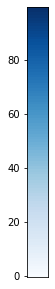

In [57]:
a=np.outer(np.arange(0,1,0.01),np.ones(10))

f = plt.figure(figsize=(0.3,5))
plt.subplots_adjust(top=0.8,bottom=0.05,left=0.01,right=0.99)
plt.gca().xaxis.set_visible(False)
locs, labels = plt.xticks()
plt.xticks(locs, [0, 0.2, 0.4, 0.6, 0.8, 1]) 
plt.imshow(a, aspect='auto', cmap = matplotlib.cm.get_cmap('Blues'),origin="lower")
f.savefig("models/interpret/bar.svg", dpi=300)